<a href="https://colab.research.google.com/github/varunpothu/Smart_HealthCare_Chatbot/blob/main/medicine_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing all Required Libraries

In [1]:
# Install TensorFlow
!pip install tensorflow

# Install pandas and numpy
!pip install pandas numpy

# Install scikit-learn
!pip install scikit-learn

# Install fuzzywuzzy
!pip install fuzzywuzzy

# Install python-Levenshtein (required for fuzzywuzzy)
!pip install python-Levenshtein

# Install joblib
!pip install joblib

# Install pyngrok
!pip install pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.6 MB/s eta 0:00:00


### Importing Libraries

In [17]:
# Import Required Libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from fuzzywuzzy import process
import joblib
from threading import Thread
from pyngrok import ngrok
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

### Data Loading

In [3]:

# File Paths
file1_path = '/content/drive/MyDrive/1.csv'
file5_path = '/content/drive/MyDrive/5.csv'

# Load Datasets
data1 = pd.read_csv(file1_path)
data5 = pd.read_csv(file5_path)

<ipython-input-3-2e3871ba6710>:7: DtypeWarning: Columns (42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data5 = pd.read_csv(file5_path)


### Data Preprocessing

In [4]:
# Rename Columns for Consistency
data1.rename(columns={
    "Medicine Name": "medicine_name",
    "Uses": "uses",
    "Side_effects": "side_effects",
    "Image URL": "image_url",
    "Manufacturer": "manufacturer"
}, inplace=True)

In [5]:
data5.rename(columns={
    "name": "medicine_name",
    "Therapeutic Class": "therapeutic_class",
    "substitute0": "substitute_1",
    "substitute1": "substitute_2",
    "substitute2": "substitute_3",
    "substitute3": "substitute_4",
    "substitute4": "substitute_5",
    "sideEffect0": "side_effect_1",
    "sideEffect1": "side_effect_2",
    "sideEffect2": "side_effect_3",
    "use0": "use_1",
    "use1": "use_2",
    "use2": "use_3"
}, inplace=True)

In [6]:
# Normalize Medicine Names
data1['medicine_name'] = data1['medicine_name'].str.lower().str.strip()
data5['medicine_name'] = data5['medicine_name'].str.lower().str.strip()

In [7]:
# Merge Datasets
merged_data = pd.merge(data1, data5, on="medicine_name", how="outer")


In [8]:
# Combine Relevant Information with Improved Formatting
merged_data['combined_side_effects'] = merged_data[
    [col for col in merged_data.columns if 'side_effect' in col]
].apply(lambda x: ' | '.join(x.dropna().astype(str)), axis=1)

merged_data['combined_uses'] = merged_data[
    [col for col in merged_data.columns if 'use' in col]
].apply(lambda x: ' | '.join(x.dropna().astype(str)), axis=1)

merged_data['combined_substitutes'] = merged_data[
    [col for col in merged_data.columns if 'substitute' in col]
].apply(lambda x: ' | '.join(x.dropna().astype(str)), axis=1)

In [9]:
# Handle Missing Values
merged_data.fillna("Not Available", inplace=True)

<ipython-input-9-c34294255131>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not Available' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.fillna("Not Available", inplace=True)


In [10]:
# Save Merged Data
merged_data.to_csv('/content/processed_data.csv', index=False)

### Tokenizing

In [11]:
# Tokenize and Pad Sequences
tokenizer = Tokenizer()
texts = merged_data['medicine_name'] + ' ' + merged_data['combined_uses'] + ' ' + merged_data['combined_side_effects']
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=100)

# Encoding Labels

In [12]:
# Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(merged_data['therapeutic_class'])

Train - Test Split

In [13]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Implementation

GRU Model

In [14]:
# Build and Train GRU Model
gru_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=100),
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(32)),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)


Epoch 1/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 66s 20ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9870 - val_loss: 0.0748
Epoch 2/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.9992 - loss: 0.0026 - val_accuracy: 0.9892 - val_loss: 0.0690
Epoch 3/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9882 - val_loss: 0.0765
Epoch 4/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9873 - val_loss: 0.0859
Epoch 5/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9820 - val_loss: 0.1008
Epoch 6/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9876 - val_loss: 0.0893
Epoch 7/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9862 - val_loss: 0.0905
Epoch 8/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - accuracy: 0.9995 -

In [34]:
# Evaluate the model
evaluation_metrics = gru_model.evaluate(X_test, y_test, verbose=0)
loss, accuracy = evaluation_metrics

# Predict on test data
y_pred = gru_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Generate classification report
report = classification_report(y_test, y_pred_classes, output_dict=True)

report_df = pd.DataFrame(report).transpose()

1558/1558 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


In [36]:
# classification report
report = classification_report(y_test, y_pred_classes, output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Display the classification report as a DataFrame
report_df


,precision,recall,f1-score,support
0,0.997865,0.997865,0.997865,2342.000000
1,0.996299,0.988029,0.992147,11444.000000
2,0.985337,0.991150,0.988235,339.000000
3,0.978693,0.997106,0.987814,691.000000
4,0.983755,0.964602,0.974084,565.000000
5,0.994544,0.998084,0.996311,3653.000000
6,0.972062,0.982952,0.977476,2053.000000
7,0.988912,0.992387,0.990646,6830.000000
8,0.971366,0.989899,0.980545,891.000000
9,0.995438,0.989121,0.992269,1103.000000


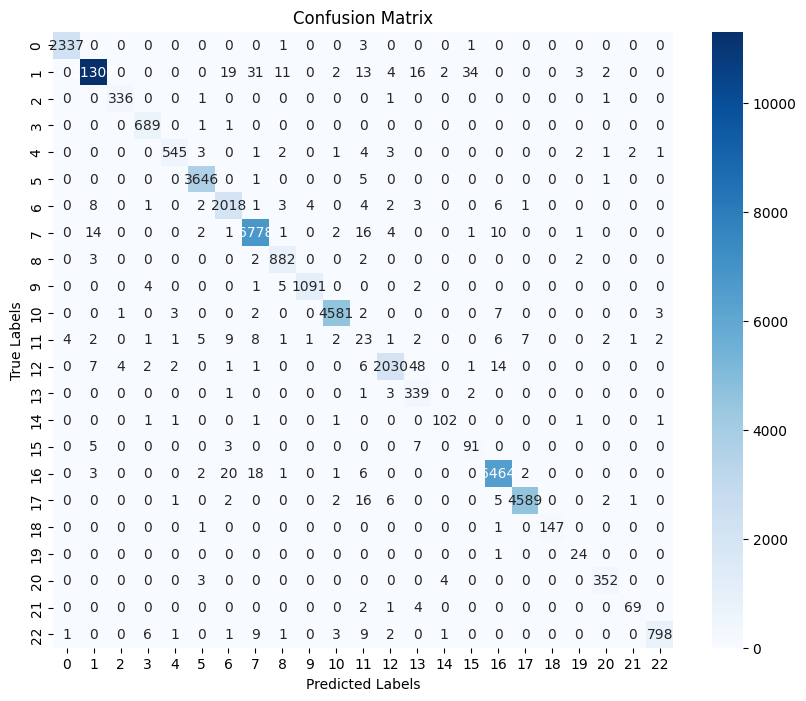

In [37]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [20]:
# saving model
gru_model.save('/content/gru_model.h5')

LSTM Model

In [19]:
# Build and Train LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)


Epoch 1/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - accuracy: 0.8620 - loss: 0.5506 - val_accuracy: 0.9873 - val_loss: 0.0628
Epoch 2/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9891 - loss: 0.0516 - val_accuracy: 0.9888 - val_loss: 0.0538
Epoch 3/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.9933 - loss: 0.0305 - val_accuracy: 0.9869 - val_loss: 0.0557
Epoch 4/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9956 - loss: 0.0190 - val_accuracy: 0.9892 - val_loss: 0.0490
Epoch 5/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9967 - loss: 0.0135 - val_accuracy: 0.9910 - val_loss: 0.0479
Epoch 6/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9976 - loss: 0.0094 - val_accuracy: 0.9891 - val_loss: 0.0525
Epoch 7/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9978 - loss: 0.0083 - val_accuracy: 0.9916 - val_loss: 0.0507
Epoch 8/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9986 -

In [38]:
# Evaluate the model
evaluation_metrics = lstm_model.evaluate(X_test, y_test, verbose=0)
loss, accuracy = evaluation_metrics

# Predict on test data
y_pred = lstm_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Generate classification report
report = classification_report(y_test, y_pred_classes, output_dict=True)

report_df = pd.DataFrame(report).transpose()

1558/1558 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


In [39]:
# classification report
report = classification_report(y_test, y_pred_classes, output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Display the classification report as a DataFrame
report_df


,precision,recall,f1-score,support
0,0.997861,0.996157,0.997009,2342.000000
1,0.996842,0.993009,0.994922,11444.000000
2,1.000000,0.991150,0.995556,339.000000
3,0.985507,0.984081,0.984794,691.000000
4,0.959720,0.969912,0.964789,565.000000
5,0.996986,0.996168,0.996577,3653.000000
6,0.979136,0.982952,0.981040,2053.000000
7,0.991074,0.991654,0.991364,6830.000000
8,0.976744,0.989899,0.983278,891.000000
9,0.995459,0.993654,0.994555,1103.000000


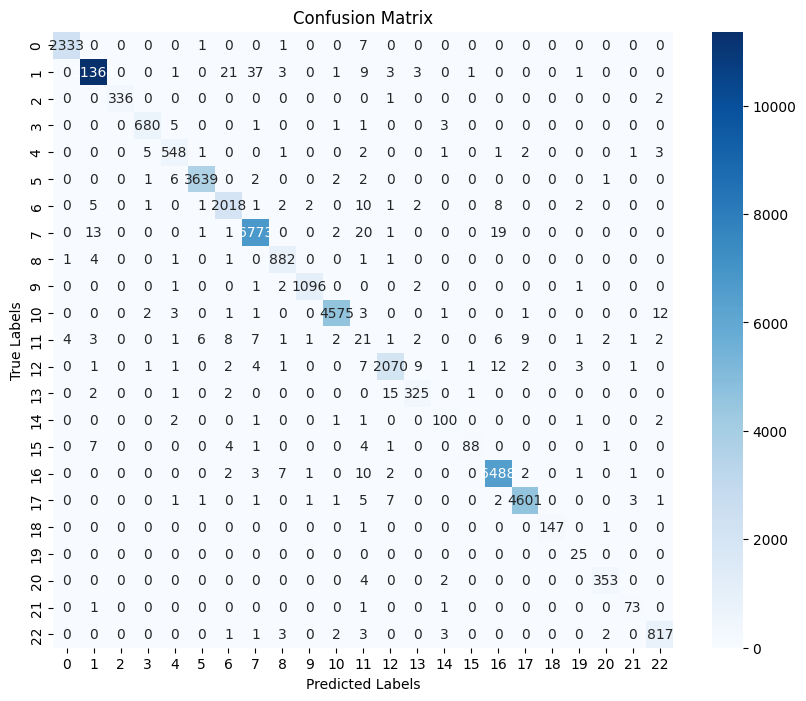

In [40]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [41]:
lstm_model.save('/content/lstm_model.h5')

In [ ]:
# Save Label Encoder and Tokenizer
joblib.dump(label_encoder, '/content/label_encoder.pkl')
joblib.dump(tokenizer, '/content/tokenizer.pkl')

### Deployment using Streamlit

In [ ]:
# Streamlit App Script
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
from fuzzywuzzy import process

# Load Models and Data
gru_model = load_model('/content/gru_model.h5')
tokenizer = joblib.load('/content/tokenizer.pkl')
label_encoder = joblib.load('/content/label_encoder.pkl')
merged_data = pd.read_csv('/content/processed_data.csv')

# Fuzzy Matching
def correct_medicine_name(input_name):
    matched_name, score = process.extractOne(input_name.lower(), merged_data['medicine_name'].values)
    return matched_name if score > 80 else None

# Enhanced Query System
def get_medicine_details(medicine_name):
    corrected_name = correct_medicine_name(medicine_name)
    if corrected_name:
        details = merged_data[merged_data['medicine_name'] == corrected_name].iloc[0]
        return {
            "Medicine Name": details['medicine_name'],
            "Uses": details['combined_uses'],
            "Side Effects": details['combined_side_effects'],
            "Substitutes": details['combined_substitutes'],
            "Therapeutic Class": details['therapeutic_class'],
            "Image URL": details['image_url'],
            "Manufacturer": details['manufacturer']
        }
    else:
        return {"Error": "Medicine not found. Please check the spelling or try another name."}

# Streamlit App
st.title("Healthcare Chatbot")
user_input = st.text_input("Enter Medicine Name:", "")

if user_input:
    details = get_medicine_details(user_input)
    if "Error" in details:
        st.write(details["Error"])
    else:
        st.write("### Medicine Details:")
        for key, value in details.items():
            if key == "Image URL" and value != "Not Available":
                st.image(value, caption="Medicine Image")
            else:
                st.write(f"**{key}:** {value}")
    """)


Using Ngrok Autoken

In [42]:
 # Deploy App with Ngrok
!ngrok authtoken 2pPynQ1umOErGUuiyW31IDnmrF1_6VvhjMYosxEu6cnK5g3jx
def run_streamlit():
    os.system("streamlit run app.py --server.address 0.0.0.0 --server.port 8501")

thread = Thread(target=run_streamlit)
thread.start()
public_url = ngrok.connect(addr="8501", proto="http", bind_tls=True)
print(f"Your app is live at: {public_url}")


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Your app is live at: NgrokTunnel: "https://b382-34-124-158-95.ngrok-free.app" -> "http://localhost:8501"
